# Boston housing data

In [1]:
%connect_info

{
  "shell_port": 39765,
  "iopub_port": 50889,
  "stdin_port": 55539,
  "control_port": 58877,
  "hb_port": 43693,
  "ip": "127.0.0.1",
  "key": "1d4adb74-f9c3a7ab17733dabea4fd649",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-25597318-8275-49ce-a1cb-a16c1c105954.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


https://mljar.com/blog/feature-importance-xgboost/

## Load libraries

In [2]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

## Get data

Load the boston data

In [3]:
boston = load_boston()

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [7]:
df['target'] = boston.target

In [8]:
df['CHAS'] = df.CHAS.astype('boolean')

## Summarize data

In [9]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

In [10]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       boolean
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
target     float64
dtype: object

In [11]:
df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Descriptive analysis

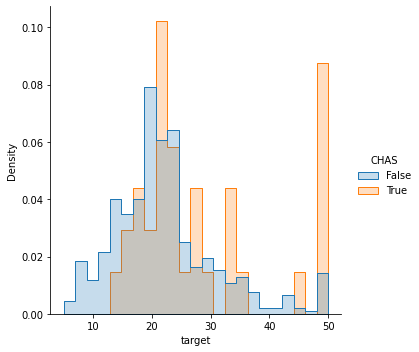

In [12]:
sns.displot(x='target', hue='CHAS', stat='density',
            common_norm=False, data=df, element='step')

In [13]:
features = set(df.columns) - set(['CHAS'])

Display correlation table

In [14]:
corr = df[features].corr()

Display features with high correlation with the target

In [15]:
corr[['target']].sort_values('target', ascending=False)

,target
target,1.000000
RM,0.695360
ZN,0.360445
B,0.333461
DIS,0.249929
AGE,-0.376955
RAD,-0.381626
CRIM,-0.388305
NOX,-0.427321
TAX,-0.468536


Correlation table

In [16]:
features = set(df.columns) - set(['CHAS', 'target'])
corr = df[features].corr()
corr

,CRIM,LSTAT,PTRATIO,INDUS,ZN,DIS,RM,NOX,AGE,RAD,B,TAX
CRIM,1.000000,0.455621,0.289946,0.406583,-0.200469,-0.379670,-0.219247,0.420972,0.352734,0.625505,-0.385064,0.582764
LSTAT,0.455621,1.000000,0.374044,0.603800,-0.412995,-0.496996,-0.613808,0.590879,0.602339,0.488676,-0.366087,0.543993
PTRATIO,0.289946,0.374044,1.000000,0.383248,-0.391679,-0.232471,-0.355501,0.188933,0.261515,0.464741,-0.177383,0.460853
INDUS,0.406583,0.603800,0.383248,1.000000,-0.533828,-0.708027,-0.391676,0.763651,0.644779,0.595129,-0.356977,0.720760
ZN,-0.200469,-0.412995,-0.391679,-0.533828,1.000000,0.664408,0.311991,-0.516604,-0.569537,-0.311948,0.175520,-0.314563
DIS,-0.379670,-0.496996,-0.232471,-0.708027,0.664408,1.000000,0.205246,-0.769230,-0.747881,-0.494588,0.291512,-0.534432
RM,-0.219247,-0.613808,-0.355501,-0.391676,0.311991,0.205246,1.000000,-0.302188,-0.240265,-0.209847,0.128069,-0.292048
NOX,0.420972,0.590879,0.188933,0.763651,-0.516604,-0.769230,-0.302188,1.000000,0.731470,0.611441,-0.380051,0.668023
AGE,0.352734,0.602339,0.261515,0.644779,-0.569537,-0.747881,-0.240265,0.731470,1.000000,0.456022,-0.273534,0.506456
RAD,0.625505,0.488676,0.464741,0.595129,-0.311948,-0.494588,-0.209847,0.611441,0.456022,1.000000,-0.444413,0.910228


<AxesSubplot:>

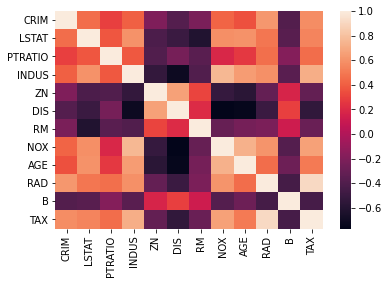

In [17]:
sns.heatmap(corr)

Get high correlation features

In [18]:
threshold = 0.9
high_corr_pairs = []
for col in corr:
    abs_corr = corr[col].abs()
    high_corr = corr[col][(abs_corr > threshold) & (abs_corr < 1)]
    if len(high_corr.index.values) > 0:
        for key in high_corr.index.values:
            high_corr_pairs.append(tuple(sorted((col, key))))

In [19]:
set(high_corr_pairs)

{('RAD', 'TAX')}

## Plot of numeric variable with target

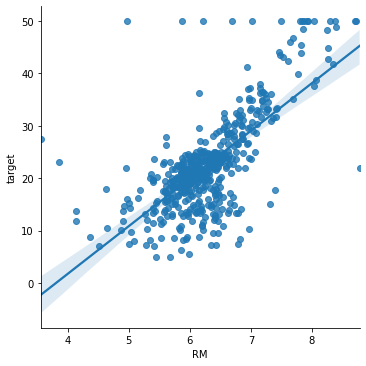

In [20]:
sns.lmplot(data=df, x='RM', y='target')

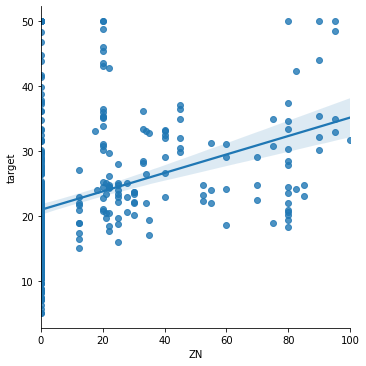

In [21]:
sns.lmplot(data=df, x='ZN', y='target')

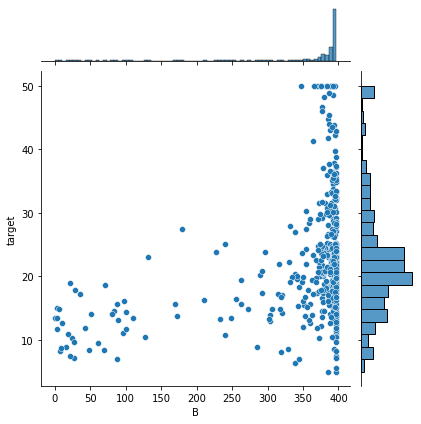

In [22]:
sns.jointplot(data=df, x='B', y='target')

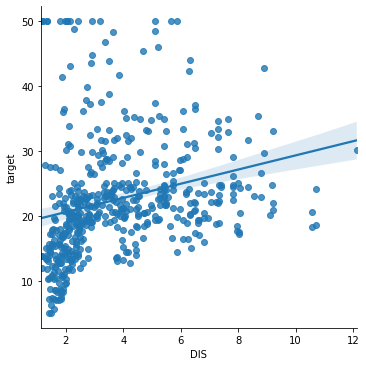

In [23]:
sns.lmplot(data=df, x='DIS', y='target')

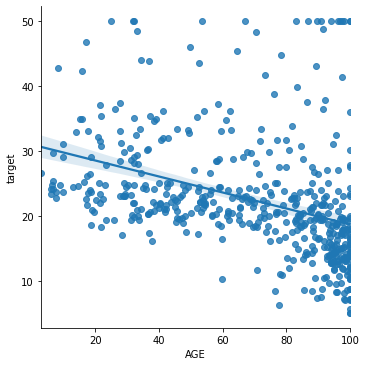

In [24]:
sns.lmplot(data=df, x='AGE', y='target')

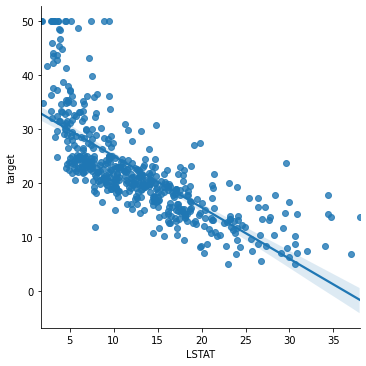

In [25]:
sns.lmplot(data=df, x='LSTAT', y='target')

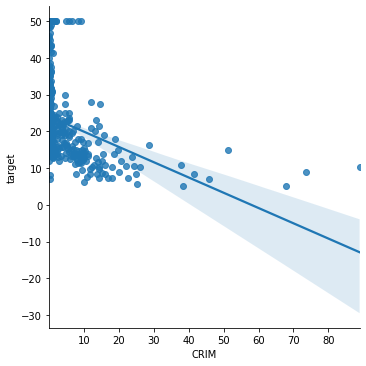

In [26]:
sns.lmplot(data=df, x='CRIM', y='target')